In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torchvision import transforms
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image


def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "not_humanitarian":
    return 0
  elif text == "infrastructure_and_utility_damage":
    return 1
  elif text == "other_relevant_information":
    return 2
  elif text == "rescue_volunteering_or_donation_effort":
    return 3
  elif text == "affected_individuals":
    return 4

df_train = pd.read_csv("./gdrive/MyDrive/Models/train.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/Models/val.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/Models/test.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [ ]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.paths = paths
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    for param in self.bert.parameters():
      param.requires_grad = False
    
    self.densenet = torchvision.models.densenet161(pretrained=True)
    for param in self.densenet.parameters():
      param.requires_grad = False
    
    self.bn = nn.BatchNorm1d(self.bert.config.hidden_size + 1000)

    self.linear1 = nn.Linear(self.bert.config.hidden_size + 1000, 1000)
    self.relu1    = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.linear2 = nn.Linear(1000, 500)
    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)

    self.linear3 = nn.Linear(500, 250)
    self.relu3    = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    self.linear4 = nn.Linear(250, 125)
    self.relu4    = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.02)

    self.linear5 = nn.Linear(125, 5)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input_ids, attention_mask, tweet_img):
    _, text_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    image_output = self.densenet(tweet_img)
    merged_output = torch.cat((text_output, image_output), dim=1)
    bn_output = self.bn(merged_output)

    linear1_output = self.linear1(bn_output)
    relu1_output = self.relu1(linear1_output)
    dropout1_output = self.dropout1(relu1_output)

    linear2_output = self.linear2(dropout1_output)
    relu2_output = self.relu2(linear2_output)
    dropout2_output = self.dropout2(relu2_output)

    linear3_output = self.linear3(dropout2_output)
    relu3_output = self.relu3(linear3_output)
    dropout3_output = self.dropout3(relu3_output)

    linear4_output = self.linear4(dropout3_output)
    relu4_output = self.relu4(linear4_output)
    dropout4_output = self.dropout4(relu4_output)

    linear5_output = self.linear5(dropout4_output)


    probas = self.softmax(linear5_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].long()
    targets = targets.to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.max(outputs, dim=1).indices == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
BATCH_SIZE = 512
MAX_LEN = 150

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 70

optimizer = AdamW(model.parameters(), lr=1e-2)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Epoch 1/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 2.8672852367162704 accuracy 0.5226901730329742
Val   loss 0.8006501793861389 accuracy 0.6492985971943888
Epoch 2/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6754341175158819 accuracy 0.7615083251714005
Val   loss 0.6905445158481598 accuracy 0.75250501002004
Epoch 3/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5589615032076836 accuracy 0.8090107737512243
Val   loss 0.6341380476951599 accuracy 0.7765531062124248
Epoch 4/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5166925887266794 accuracy 0.8246816846229187
Val   loss 0.6752055585384369 accuracy 0.7675350701402806
Epoch 5/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.48635520537694293 accuracy 0.8325171400587659
Val   loss 0.5804504752159119 accuracy 0.8106212424849699
Epoch 6/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4269205455978711 accuracy 0.8545543584720862
Val   loss 0.6048908531665802 accuracy 0.8096192384769538
Epoch 7/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.40629177043835324 accuracy 0.8583088475350963
Val   loss 0.6380390524864197 accuracy 0.7865731462925851
Epoch 8/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3835893049836159 accuracy 0.8601044727391446
Val   loss 0.6783261597156525 accuracy 0.7985971943887775
Epoch 9/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.365551916261514 accuracy 0.8620633365981064
Val   loss 0.7098752558231354 accuracy 0.7955911823647294
Epoch 10/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3633745089173317 accuracy 0.8684296441397322
Val   loss 0.6976792514324188 accuracy 0.7985971943887775
Epoch 11/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3191033328572909 accuracy 0.8875285667646099
Val   loss 0.664669007062912 accuracy 0.812625250501002
Epoch 12/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3140089785059293 accuracy 0.8886712373490042
Val   loss 0.7387233674526215 accuracy 0.8106212424849699
Epoch 13/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2852904337147872 accuracy 0.8934051583414953
Val   loss 0.7160923480987549 accuracy 0.7995991983967935
Epoch 14/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26851017276446026 accuracy 0.9043421482206987
Val   loss 0.7823622226715088 accuracy 0.7935871743486973
Epoch 15/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.25853365411361057 accuracy 0.8996082272282077
Val   loss 0.7583682537078857 accuracy 0.8026052104208417
Epoch 16/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.25815602019429207 accuracy 0.9121776036565459
Val   loss 0.7465124130249023 accuracy 0.7955911823647294
Epoch 17/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24984108159939447 accuracy 0.9097290238328436
Val   loss 0.8041724562644958 accuracy 0.8096192384769538
Epoch 18/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23522243152062097 accuracy 0.9175644792686908
Val   loss 0.832811027765274 accuracy 0.8026052104208417
Epoch 19/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23632078617811203 accuracy 0.9165850473392099
Val   loss 1.0061123371124268 accuracy 0.8106212424849699
Epoch 20/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22955837349096933 accuracy 0.9149526607900751
Val   loss 0.929828554391861 accuracy 0.8056112224448897
Epoch 21/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2589319398005803 accuracy 0.9074436826640548
Val   loss 0.9895966649055481 accuracy 0.7945891783567134
Epoch 22/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22790200263261795 accuracy 0.9193601044727391
Val   loss 1.0014630556106567 accuracy 0.7985971943887775
Epoch 23/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20226068422198296 accuracy 0.9278485145282402
Val   loss 1.0627877116203308 accuracy 0.7775551102204408
Epoch 24/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18999618912736574 accuracy 0.9327456741756448
Val   loss 1.2503862977027893 accuracy 0.8036072144288576
Epoch 25/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19456618651747704 accuracy 0.9382957884427032
Val   loss 1.165956735610962 accuracy 0.7905811623246493
Epoch 26/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18634729521969953 accuracy 0.9276852758733268
Val   loss 1.1063226461410522 accuracy 0.8166332665330661
Epoch 27/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16816776804625988 accuracy 0.9409076069213189
Val   loss 1.1576799750328064 accuracy 0.7965931863727455
Epoch 28/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.152553278952837 accuracy 0.9474371531178583
Val   loss 1.238933801651001 accuracy 0.8016032064128256
Epoch 29/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1309941733876864 accuracy 0.9521710741103493
Val   loss 1.5276848077774048 accuracy 0.8036072144288576
Epoch 30/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11743441286186378 accuracy 0.9573947110675808
Val   loss 1.9042633175849915 accuracy 0.7965931863727455
Epoch 31/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15004768470923105 accuracy 0.9487430623571661
Val   loss 2.0692643523216248 accuracy 0.8046092184368737
Epoch 32/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1620668601244688 accuracy 0.94564152791381
Val   loss 1.5961512923240662 accuracy 0.7905811623246493
Epoch 33/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16985109883050123 accuracy 0.944662095984329
Val   loss 1.3761672973632812 accuracy 0.8016032064128256
Epoch 34/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11749980474511783 accuracy 0.9606594841658505
Val   loss 1.4142783284187317 accuracy 0.7965931863727455
Epoch 35/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.08850631987055142 accuracy 0.970617042115573
Val   loss 1.417103111743927 accuracy 0.7895791583166332
Epoch 36/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.07229707576334476 accuracy 0.9743715311785831
Val   loss 1.5573020577430725 accuracy 0.7935871743486973
Epoch 37/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.07349393920352061 accuracy 0.9760039177277179
Val   loss 1.7956116795539856 accuracy 0.7915831663326652
Epoch 38/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.08025396335870028 accuracy 0.9727391446294482
Val   loss 1.5444982051849365 accuracy 0.7885771543086172
Epoch 39/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.07869984582066536 accuracy 0.9738818152138426
Val   loss 1.813061237335205 accuracy 0.8116232464929859
Epoch 40/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0785227349648873 accuracy 0.9738818152138426
Val   loss 1.813353955745697 accuracy 0.7965931863727455
Epoch 41/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.07367223283896844 accuracy 0.9773098269670257
Val   loss 1.64379221200943 accuracy 0.7955911823647294
Epoch 42/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.06415854239215453 accuracy 0.9799216454456415
Val   loss 1.6276476979255676 accuracy 0.785571142284569
Epoch 43/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.05837971499810616 accuracy 0.980411361410382
Val   loss 1.754154920578003 accuracy 0.7935871743486973
Epoch 44/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.05487192949901024 accuracy 0.9853085210577864
Val   loss 1.89372718334198 accuracy 0.7955911823647294
Epoch 45/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.04956022851789991 accuracy 0.984818805093046
Val   loss 1.9898123145103455 accuracy 0.7865731462925851
Epoch 46/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.04596554161980748 accuracy 0.9853085210577864
Val   loss 2.014064371585846 accuracy 0.7795591182364728
Epoch 47/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0361294544612368 accuracy 0.9872673849167483
Val   loss 2.3451168537139893 accuracy 0.7895791583166332
Epoch 48/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.04313994183515509 accuracy 0.9864511916421809
Val   loss 2.3162784576416016 accuracy 0.7965931863727455
Epoch 49/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.03690096829086542 accuracy 0.9874306235716618
Val   loss 2.0156842470169067 accuracy 0.7905811623246493
Epoch 50/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.045888405914107956 accuracy 0.9856349983676135
Val   loss 2.0589759349823 accuracy 0.7865731462925851
Epoch 51/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.037250043358653784 accuracy 0.9892262487757101
Val   loss 1.8702839016914368 accuracy 0.7915831663326652
Epoch 52/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.031701467698439956 accuracy 0.9903689193601044
Val   loss 2.2157593965530396 accuracy 0.8016032064128256
Epoch 53/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.024497965816408396 accuracy 0.9918380672543258
Val   loss 2.4210453033447266 accuracy 0.7925851703406813
Epoch 54/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.029025787642846506 accuracy 0.9913483512895853
Val   loss 2.4534419775009155 accuracy 0.8076152304609218
Epoch 55/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.02510311547666788 accuracy 0.9920013059092393
Val   loss 2.4022237062454224 accuracy 0.7955911823647294
Epoch 56/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.028203072492033243 accuracy 0.9908586353248449
Val   loss 2.3994640111923218 accuracy 0.7945891783567134
Epoch 57/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.026225565078978736 accuracy 0.9920013059092393
Val   loss 2.3480031490325928 accuracy 0.7975951903807614
Epoch 58/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.018601426233847935 accuracy 0.9941234084231145
Val   loss 2.3853765726089478 accuracy 0.7935871743486973
Epoch 59/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.01654119440354407 accuracy 0.9944498857329416
Val   loss 2.577750086784363 accuracy 0.8016032064128256
Epoch 60/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.015365026270349821 accuracy 0.9955925563173359
Val   loss 2.68966805934906 accuracy 0.8036072144288576
Epoch 61/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.01401583336216087 accuracy 0.9941234084231145
Val   loss 2.699357748031616 accuracy 0.7965931863727455
Epoch 62/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.013227635257256528 accuracy 0.9951028403525954
Val   loss 2.768269181251526 accuracy 0.8046092184368737
Epoch 63/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.015101493491480747 accuracy 0.9955925563173359
Val   loss 2.7202727794647217 accuracy 0.7985971943887775
Epoch 64/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.017507767925659817 accuracy 0.9947763630427685
Val   loss 2.73159122467041 accuracy 0.8006012024048096
Epoch 65/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.019298016947383683 accuracy 0.995266079007509
Val   loss 2.6779403686523438 accuracy 0.8036072144288576
Epoch 66/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.01591914057886849 accuracy 0.9947763630427685
Val   loss 2.5877134799957275 accuracy 0.7965931863727455
Epoch 67/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.0101121526871187 accuracy 0.9968984655566437
Val   loss 2.5956685543060303 accuracy 0.7985971943887775
Epoch 68/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.013248983188532293 accuracy 0.995266079007509
Val   loss 2.6150827407836914 accuracy 0.8016032064128256
Epoch 69/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.01589465808744232 accuracy 0.994939601697682
Val   loss 2.608080744743347 accuracy 0.8036072144288576
Epoch 70/70
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.011688737858397266 accuracy 0.9965719882468168
Val   loss 2.6091039180755615 accuracy 0.8046092184368737


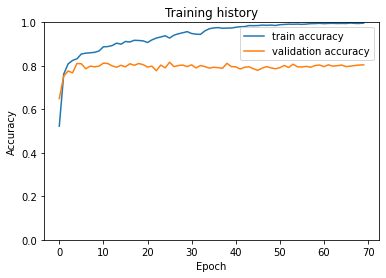

In [ ]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/BertDenseNet/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']

# print(start_epoch)
# print(best_accuracy)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/BertDenseNet/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc


state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/BertDenseNet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/BertDenseNet/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

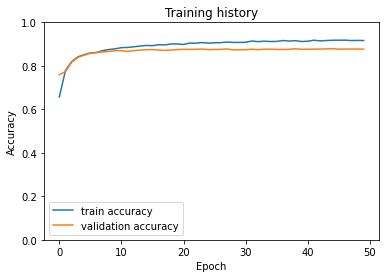

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      tweet_imgs = d["tweet_image"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].long()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )
      preds = torch.max(outputs, dim=1).indices


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['not_humanitarian', 'infrastructure_and_utility_damage', 'other_relevant_information', 'rescue_volunteering_or_donation_effort', 'affected_individuals'], digits = 4))

                                        precision    recall  f1-score   support

                      not_humanitarian     0.8623    0.9067    0.8839       504
     infrastructure_and_utility_damage     0.8193    0.8395    0.8293        81
            other_relevant_information     0.8591    0.8043    0.8308       235
rescue_volunteering_or_donation_effort     0.8288    0.7302    0.7764       126
                  affected_individuals     0.5455    0.6667    0.6000         9

                              accuracy                         0.8503       955
                             macro avg     0.7830    0.7895    0.7841       955
                          weighted avg     0.8504    0.8503    0.8494       955

